# Clustering

In [108]:
import os
import pandas as pd
import numpy as np
import qiime2 as q2
from qiime2 import Visualization
from scipy.stats import shapiro, kruskal, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [109]:
data_dir = 'project_data'


if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

## 1. Data Import

In [84]:
#filtered sequence
! wget -nv -O $data_dir/rep-seqs.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza'

# Feature Table
! wget -nv -O $data_dir/table.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza'

# Taxonomy file generate from silva
! wget -nv -O $data_dir/taxonomy_1.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza'

# Phylogeny file 
! wget -nv -O $data_dir/fasttree-tree-rooted.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza'

# Metadata
! wget -nv -O $data_dir/sample_metadata.tsv 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv'

2022-12-18 14:15:25 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza [390624/390624] -> "project_data/rep-seqs.qza" [1]
2022-12-18 14:15:25 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza [504534/504534] -> "project_data/table.qza" [1]
2022-12-18 14:15:26 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=taxonomy_1.qza [303165/303165] -> "project_data/taxonomy_1.qza" [1]
2022-12-18 14:15:26 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=fasttree-tree-rooted.qza [249852/249852] -> "project_data/fasttree-tree-rooted.qza" [1]
2022-12-18 14:15:27 URL:https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=metadata-nutrition.tsv [300302/300302] -> "project_data/sample_metadata.tsv" [1]


## 2. Join metadata and feature table

In [136]:
metadata_df = pd.read_csv(f'project_data/sample_metadata_csv.csv', float_precision='round_trip')
metadata_df['sampleid'] = metadata_df['sampleid'].str.replace('-','.')
metadata_df = metadata_df.set_index('sampleid')
metadata_df.index.name = None
metadata_df= metadata_df.sort_index(ascending=True)
metadata_df

,GEN_age_cat,GEN_age_corrected,GEN_bmi_cat,GEN_bmi_corrected,GEN_cat,GEN_collection_timestamp,GEN_country,GEN_dog,GEN_elevation,GEN_geo_loc_name,...,NUT_probiotic_frequency,NUT_red_meat_frequency,NUT_salted_snacks_frequency,NUT_seafood_frequency,NUT_sugary_sweets_frequency,NUT_vegetable_frequency,NUT_vitamin_b_supplement_frequency,NUT_vitamin_d_supplement_frequency,NUT_whole_eggs,NUT_whole_grain_frequency
10317.000002929,30s,34.0,Normal,21.31,False,16.08.16 10:20,USA,False,106.1,USA:MD,...,Rarely,Rarely,Rarely,Regularly,Daily,Regularly,Never,Never,Occasionally,Regularly
10317.000002930,30s,34.0,Normal,21.31,False,04.08.16 15:20,USA,False,106.1,USA:MD,...,Rarely,Rarely,Rarely,Regularly,Daily,Regularly,Never,Never,Occasionally,Regularly
10317.000003283,30s,39.0,Normal,23.83,False,24.05.16 13:55,USA,True,1575.2,USA:CO,...,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided
10317.000004079,50s,55.0,Obese,37.32,False,30.08.16 10:30,USA,False,355.5,USA:OK,...,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided,Not provided
10317.000016169,30s,32.0,Overweight,29.79,False,23.05.16 00:00,USA,False,42.9,USA:CA,...,Never,Regularly,Regularly,Never,Regularly,Regularly,Regularly,Never,Regularly,Occasionally
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317.000062084,20s,23.0,Normal,22.15,False,19.09.16 12:17,USA,False,17.9,USA:OR,...,Never,Regularly,Regularly,Rarely,Rarely,Regularly,Never,Occasionally,Occasionally,Regularly
10317.000062085,20s,21.0,Normal,19.01,False,19.09.16 12:07,USA,False,17.9,USA:OR,...,Never,Rarely,Rarely,Rarely,Occasionally,Daily,Never,Never,Daily,Rarely
10317.000062086,20s,21.0,Overweight,25.75,True,18.09.16 12:05,USA,False,17.9,USA:OR,...,Never,Rarely,Occasionally,Rarely,Rarely,Occasionally,Rarely,Rarely,Daily,Occasionally
10317.000062087,20s,22.0,Normal,18.62,False,19.09.16 13:00,USA,False,17.9,USA:OR,...,Never,Never,Occasionally,Occasionally,Never,Regularly,Never,Never,Daily,Regularly


In [138]:
# Convert feature table to pandas: Maps sample id to feature
df_feature = q2.Artifact.load(f'{data_dir}/table.qza')
df_feature = df_feature.view(pd.DataFrame)
df_feature = df_feature.sort_index(ascending=True)
df_feature

,d46e2205f0c6ecf67b51f83d111c509c,99deb3c5ecb022ec05609ebd1112a557,f5f5e0da89730462abaf6301a9557193,fd44d4cb468fd7dc9b3227867714ed87,945184b6386c192c0066e0a98a154780,59777186ad2e0947e97615b5d6225136,263e41ea2c25dc87bd2ff5910cf30d40,4d72007c70f4abc0bf9e8fe8b826d07d,675c847bccbc53942ebb7b8cbb4efc4d,b15193fce14759d1c06728933e044af6,...,507785cd038a4e0650f1844606f53ad1,c06962c02c12a6b0dd56cb66968d827e,ab8ebba691837ccf95875676c927469c,5e21e17b7c13cac116ba54cd3b845500,2312c3c203a8fd2790dad9758c619811,dc7a907070fd0d2fdbf8b6276cce63df,1bcc579a1539b94b47ce334f316858bf,e22361cd76edf4fd1c6b4d3c37de84a8,b609812bad30be7d797121140a222bc3,9acfceacf67f31dbde50e1c671a06b19
10317.000002929,0.0,1877.0,1082.0,0.0,0.0,134.0,1336.0,0.0,0.0,513.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000002930,0.0,179.0,86.0,212.0,19.0,233.0,275.0,0.0,2348.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000003283,4625.0,1875.0,305.0,0.0,0.0,482.0,43.0,0.0,49.0,392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000004079,6.0,1719.0,106.0,0.0,0.0,1981.0,0.0,0.0,0.0,350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000016169,600.0,395.0,534.0,0.0,0.0,181.0,192.0,0.0,22.0,312.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317.000062084,2592.0,0.0,0.0,0.0,588.0,0.0,0.0,0.0,0.0,1348.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000062085,51.0,857.0,926.0,0.0,0.0,0.0,767.0,0.0,0.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000062086,54.0,394.0,341.0,0.0,0.0,233.0,208.0,0.0,0.0,555.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000062087,8.0,827.0,307.0,0.0,0.0,305.0,359.0,0.0,0.0,207.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
joined_df = metadata_df.join(df_feature)

## 3. Clustering K-Prototype

In [154]:
# Reorganise joined_df such that categorical data comes first and after continuous
df_cat = joined_df.select_dtypes(exclude='number')
df_cont = joined_df.select_dtypes(include='number')

In [160]:
joined_df = df_cat.join(df_cont)
joined_df.head()

,GEN_age_cat,GEN_bmi_cat,GEN_cat,GEN_collection_timestamp,GEN_country,GEN_dog,GEN_geo_loc_name,GEN_host_common_name,GEN_last_move,GEN_last_travel,...,507785cd038a4e0650f1844606f53ad1,c06962c02c12a6b0dd56cb66968d827e,ab8ebba691837ccf95875676c927469c,5e21e17b7c13cac116ba54cd3b845500,2312c3c203a8fd2790dad9758c619811,dc7a907070fd0d2fdbf8b6276cce63df,1bcc579a1539b94b47ce334f316858bf,e22361cd76edf4fd1c6b4d3c37de84a8,b609812bad30be7d797121140a222bc3,9acfceacf67f31dbde50e1c671a06b19
10317.000002929,30s,Normal,False,16.08.16 10:20,USA,False,USA:MD,human,I have lived in my current state of residence ...,1 year,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000002930,30s,Normal,False,04.08.16 15:20,USA,False,USA:MD,human,I have lived in my current state of residence ...,1 year,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000003283,30s,Normal,False,24.05.16 13:55,USA,True,USA:CO,human,Not provided,3 months,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000004079,50s,Obese,False,30.08.16 10:30,USA,False,USA:OK,human,Not provided,I have not been outside of my country of resid...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000016169,30s,Overweight,False,23.05.16 00:00,USA,False,USA:CA,human,I have lived in my current state of residence ...,I have not been outside of my country of resid...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
joined_df = joined_df.dropna()

In [196]:
metadata_df.columns.to_list()

['GEN_age_cat',
 'GEN_age_corrected',
 'GEN_bmi_cat',
 'GEN_bmi_corrected',
 'GEN_cat',
 'GEN_collection_timestamp',
 'GEN_country',
 'GEN_dog',
 'GEN_elevation',
 'GEN_geo_loc_name',
 'GEN_height_cm',
 'GEN_host_common_name',
 'GEN_last_move',
 'GEN_last_travel',
 'GEN_latitude',
 'GEN_level_of_education',
 'GEN_longitude',
 'GEN_race',
 'GEN_sample_type',
 'GEN_sex',
 'GEN_weight_kg',
 'NUT_alcohol_consumption',
 'NUT_alcohol_frequency',
 'NUT_alcohol_types_beercider',
 'NUT_alcohol_types_red_wine',
 'NUT_alcohol_types_sour_beers',
 'NUT_alcohol_types_spiritshard_alcohol',
 'NUT_alcohol_types_unspecified',
 'NUT_alcohol_types_white_wine',
 'NUT_artificial_sweeteners',
 'NUT_diet_type',
 'NUT_drinks_per_session',
 'NUT_fed_as_infant',
 'NUT_fermented_plant_frequency',
 'NUT_frozen_dessert_frequency',
 'NUT_fruit_frequency',
 'NUT_gluten',
 'NUT_high_fat_red_meat_frequency',
 'NUT_homecooked_meals_frequency',
 'NUT_lowgrain_diet_type',
 'NUT_meat_eggs_frequency',
 'NUT_milk_cheese_freq

In [197]:
# Remove unecessary features
joined_df = joined_df.drop(['GEN_cat', 'GEN_collection_timestamp', 'GEN_dog', 'GEN_geo_loc_name', 'GEN_host_common_name', 'GEN_last_move', 'GEN_last_travel'], axis=1)

### 3.1 Determine number of clusters

In [211]:
#! pip install kmodes
from kmodes.kprototypes import KPrototypes

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


<function matplotlib.pyplot.show(close=None, block=None)>

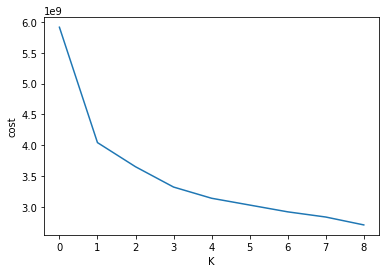

In [213]:
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(joined_df, categorical=list(range(0, 42)))
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [214]:
#! pip install kneed
from kneed import KneeLocator
cost_knee_c3 = KneeLocator(
        x=range(1,10), 
        y=cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 2 clusters


In [ ]:
### 3.2 Cluster with selected number of clusters

In [215]:
kproto = KPrototypes(n_clusters=2, init='Huang', random_state = 0)
joined_df['clusters'] = kproto.fit_predict(joined_df, categorical=list(range(0, 42)))

In [216]:
df2 = joined_df.filter(regex='GEN|clusters|NUT')

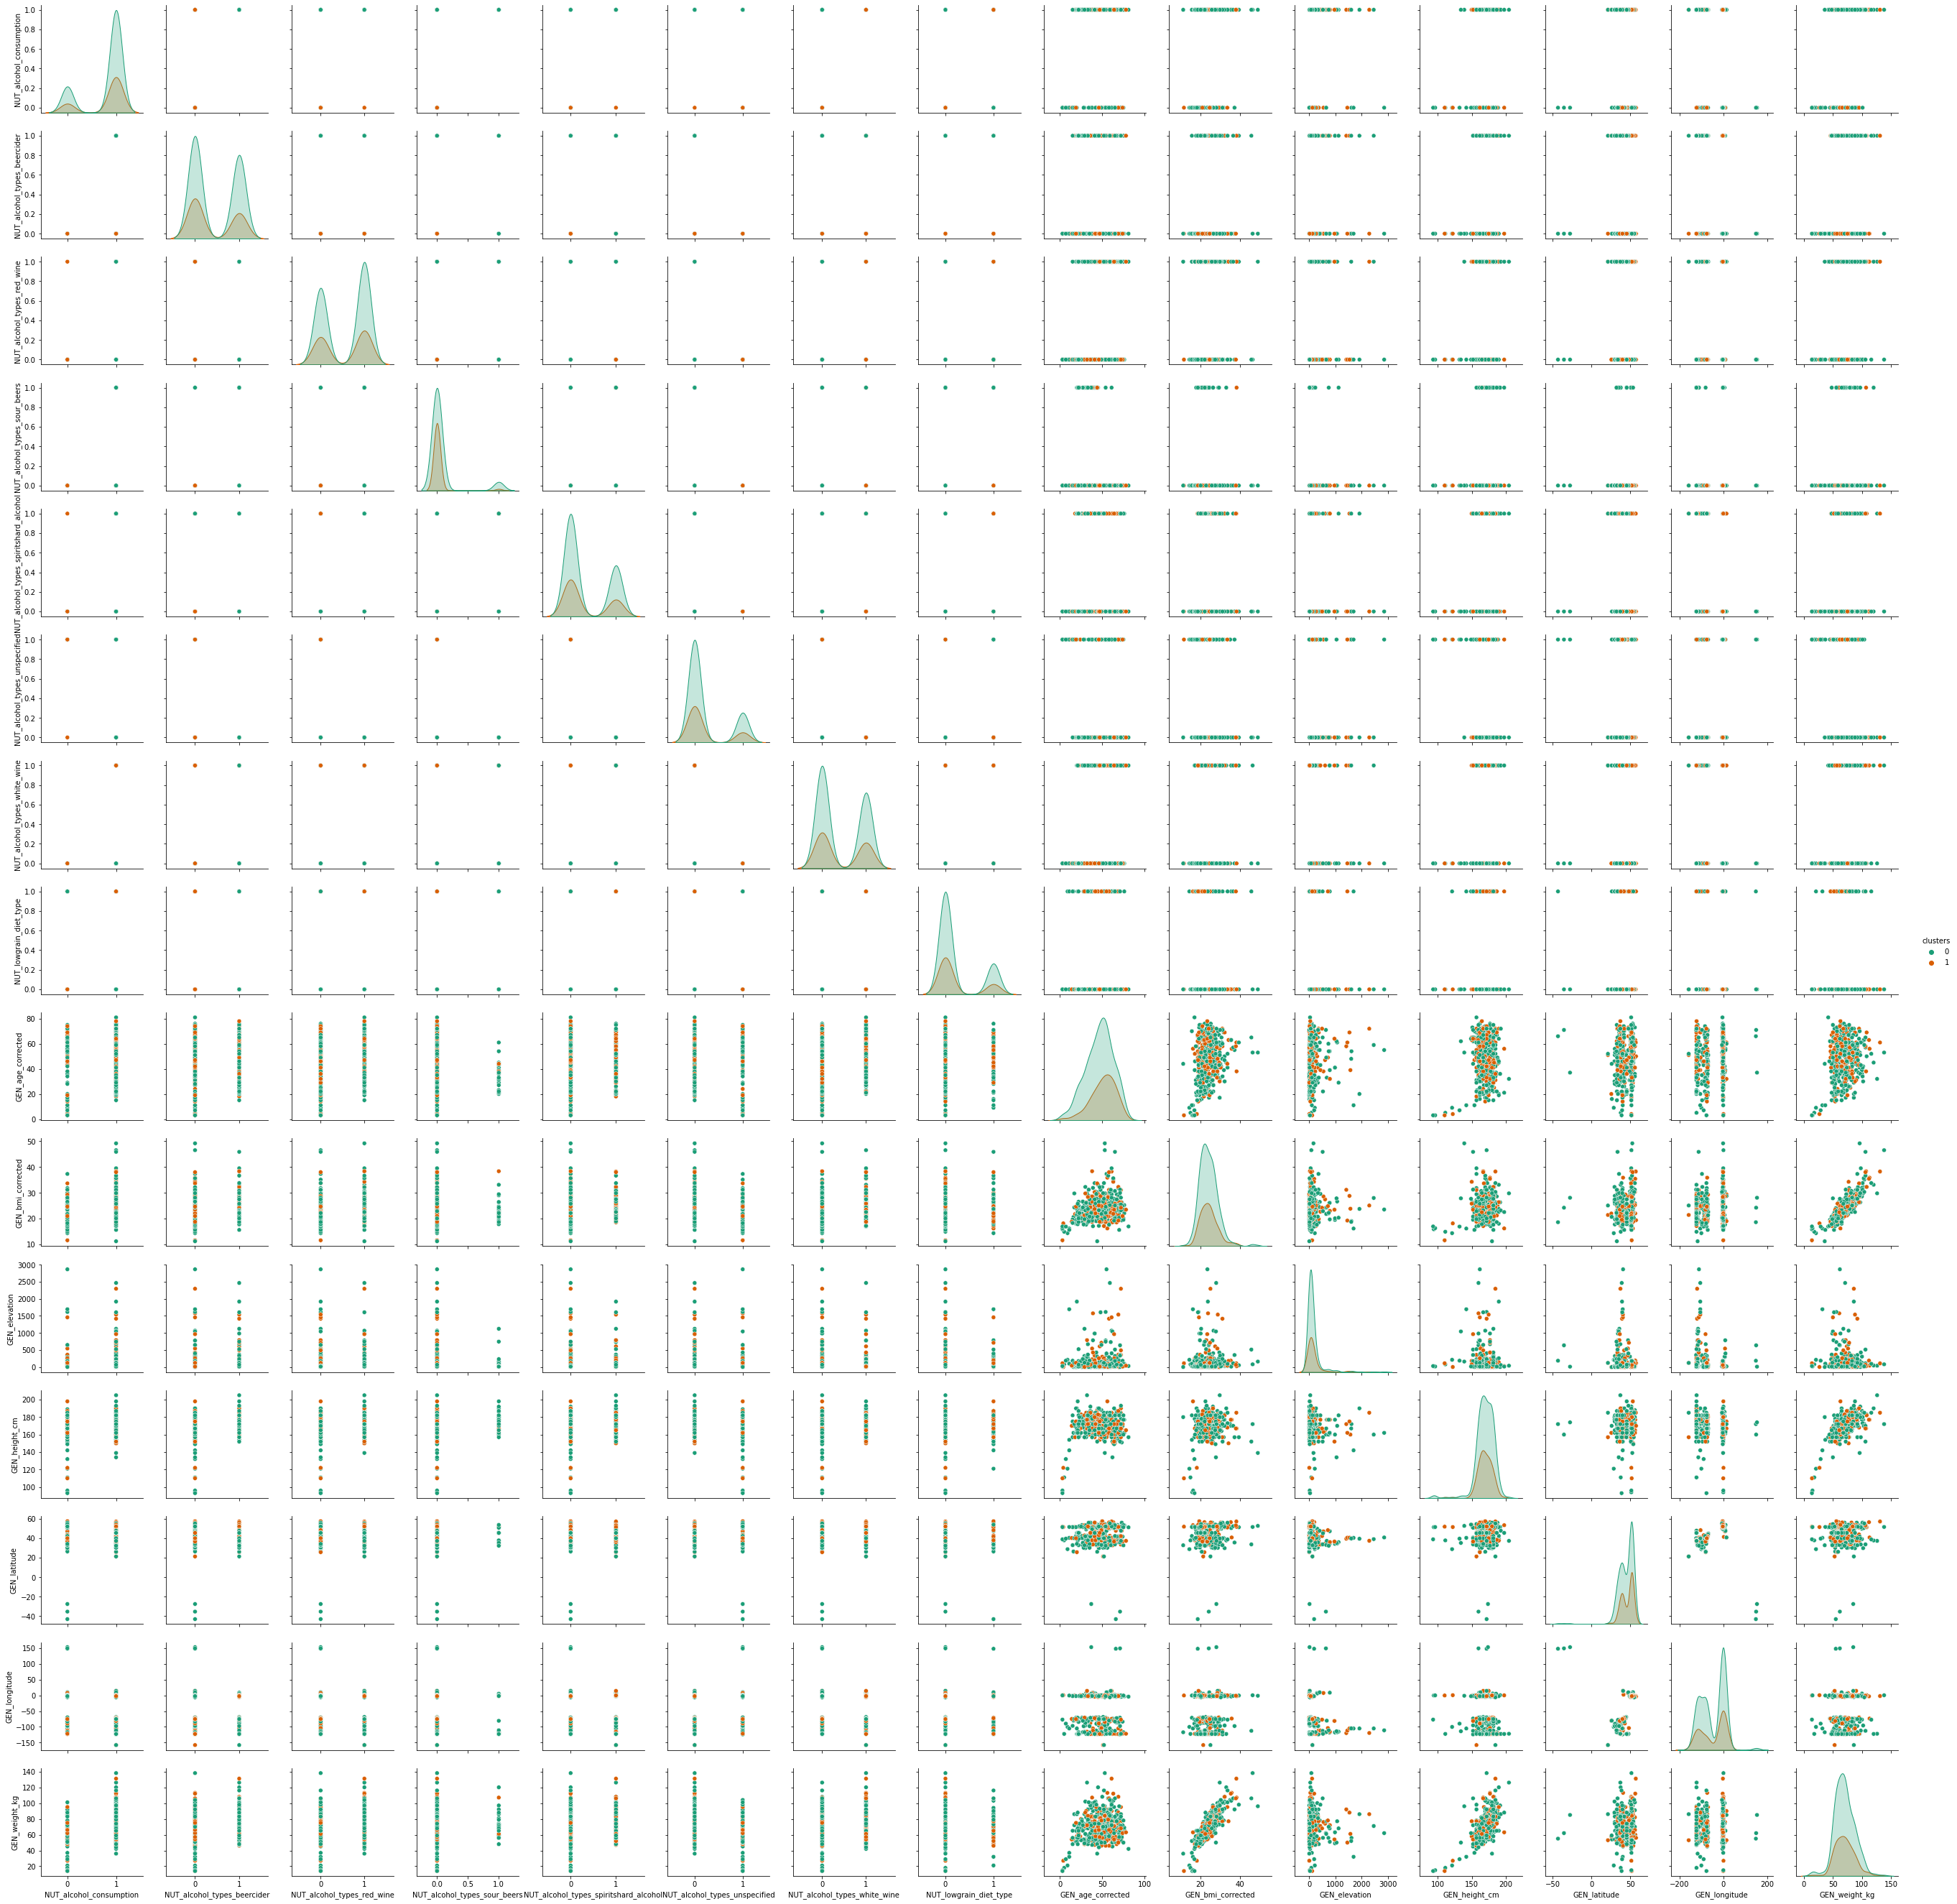

In [218]:
sns.pairplot(df2,hue='clusters',palette='Dark2',diag_kind='kde')

<AxesSubplot:>

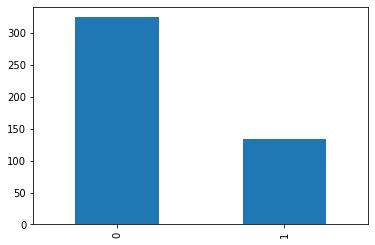

In [223]:
joined_df['clusters'].value_counts().plot(kind='bar')